<a href="https://colab.research.google.com/github/AndreYang333/ExplainableAI/blob/main/Assignment7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 7
## Minjie Yang(my189)
 Link to reference code:https://github.com/AIPI-590-XAI/Duke-AI-XAI/blob/main/explainable-ml-example-notebooks/testing_concept_activation_vectors.ipynb

 Link to github:https://github.com/AndreYang333/ExplainableAI.git

# Code Part

In [2]:
# We are going to clone the tcav repo in GitHub:
!git clone https://github.com/tensorflow/tcav.git tcav
%cd tcav
!ls

# Next, we will create the datasets
%cd /content/tcav/tcav/tcav_examples/image_models/imagenet
%run download_and_make_datasets.py --source_dir=Minjie --number_of_images_per_folder=10 --number_of_random_folders=10

%cd /content/tcav

fatal: destination path 'tcav' already exists and is not an empty directory.
/content/tcav/tcav
activation_generator.py  __init__.py	run_params.py  tcav_results   utils.py
cav.py			 model.py	tcav_examples  tcav_test.py   utils_test.py
cav_test.py		 model_test.py	tcav.py        utils_plot.py
/content/tcav/tcav/tcav_examples/image_models/imagenet
Created source directory at Minjie
Downloaded 10 for zebra
Successfully created data at Minjie
/content/tcav


In [3]:
!pip install tcav matplotlib==2.2.4 Pillow==8.2.0 scikit-learn==0.20.3 scipy==1.2.1 tensorflow==2.14.1 numpy==1.19.2 protobuf==3.10.0 pandas==1.0.3


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.0/37.0 MB 8.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.9/47.9 MB 8.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 11.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.1/23.1 MB 36.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 83.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  error: subprocess-exited-with-error
  
  × Preparing metadata (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (pyproject.toml) ... error
error: metadata-generation-failed

× Encountered error wh

In [4]:
# Basic
import os
import absl
import random
import matplotlib.pyplot as plt
from PIL import Image

# Models
import tensorflow as tf

#XAI
import tcav.activation_generator as act_gen
import tcav.cav as cav
import tcav.model  as model
import tcav.tcav as tcav
import tcav.utils as utils
import tcav.utils_plot as utils_plot


## Curate + store data
source_dir: directories for images of concepts, target class and random images. Each should be a sub-folder within this directory.

You need roughly 50-200 images per concept and target class (10-20 will work, but 200 is recommended by original paper authors).
cav_dir: directory to store CAVs (None if you don't want to store)

target, concept: names of the target class and concepts (strings) - these are folder names in source_dir

bottlenecks: list of bottleneck names (intermediate layers in your model) that you want to use for TCAV

In [5]:
# Model wrapper (InceptionV3 and GoogleNet are provided in model.py)
model_to_run = 'GoogleNet'
# Name of the parent directory that results are stored (if cacheing)
project_name = 'tcav_class_test'
working_dir = '/content/tcav/tcav'
# Location where activations are stored
activation_dir =  working_dir+ '/activations/'
# Location where CAVs are stored (or None if not storing)
cav_dir = working_dir + '/cavs/'
# Location of images
source_dir = '/content/tcav/tcav/tcav_examples/image_models/imagenet/Minjie'
# Bottleneck layer
bottlenecks = ['mixed4c']

# Create directories if they don't exist
utils.make_dir_if_not_exists(activation_dir)
utils.make_dir_if_not_exists(working_dir)
utils.make_dir_if_not_exists(cav_dir)

# Regularizer penalty parameter for linear classifier to get CAVs
alphas = [0.1]

target = 'zebra'
concepts = ["dotted","striped","zigzagged"]


In [7]:
%cp -av '/content/tcav/tcav/tcav_examples/image_models/imagenet/Minjie/mobilenet_v2_1.0_224' '/content/tcav/tcav/mobilenet_v2_1.0_224'
%rm '/content/tcav/tcav/tcav_examples/image_models/imagenet/Minjie/mobilenet_v2_1.0_224'


'/content/tcav/tcav/tcav_examples/image_models/imagenet/Minjie/mobilenet_v2_1.0_224' -> '/content/tcav/tcav/mobilenet_v2_1.0_224/mobilenet_v2_1.0_224'
'/content/tcav/tcav/tcav_examples/image_models/imagenet/Minjie/mobilenet_v2_1.0_224/mobilenet_v2_1.0_224_eval.pbtxt' -> '/content/tcav/tcav/mobilenet_v2_1.0_224/mobilenet_v2_1.0_224/mobilenet_v2_1.0_224_eval.pbtxt'
'/content/tcav/tcav/tcav_examples/image_models/imagenet/Minjie/mobilenet_v2_1.0_224/mobilenet_v2_1.0_224.ckpt.data-00000-of-00001' -> '/content/tcav/tcav/mobilenet_v2_1.0_224/mobilenet_v2_1.0_224/mobilenet_v2_1.0_224.ckpt.data-00000-of-00001'
'/content/tcav/tcav/tcav_examples/image_models/imagenet/Minjie/mobilenet_v2_1.0_224/mobilenet_v2_1.0_224_frozen.pb' -> '/content/tcav/tcav/mobilenet_v2_1.0_224/mobilenet_v2_1.0_224/mobilenet_v2_1.0_224_frozen.pb'
'/content/tcav/tcav/tcav_examples/image_models/imagenet/Minjie/mobilenet_v2_1.0_224/mobilenet_v2_1.0_224.tflite' -> '/content/tcav/tcav/mobilenet_v2_1.0_224/mobilenet_v2_1.0_224/

In [8]:

%cp -av '/content/tcav/tcav/tcav_examples/image_models/imagenet/Minjie/inception5h' '/content/tcav/tcav/inception5h'
%rm '/content/tcav/tcav/tcav_examples/image_models/imagenet/Minjie/inception5h'

'/content/tcav/tcav/tcav_examples/image_models/imagenet/Minjie/inception5h' -> '/content/tcav/tcav/inception5h'
'/content/tcav/tcav/tcav_examples/image_models/imagenet/Minjie/inception5h/imagenet_comp_graph_label_strings.txt' -> '/content/tcav/tcav/inception5h/imagenet_comp_graph_label_strings.txt'
'/content/tcav/tcav/tcav_examples/image_models/imagenet/Minjie/inception5h/tensorflow_inception_graph.pb' -> '/content/tcav/tcav/inception5h/tensorflow_inception_graph.pb'
'/content/tcav/tcav/tcav_examples/image_models/imagenet/Minjie/inception5h/LICENSE' -> '/content/tcav/tcav/inception5h/LICENSE'
rm: cannot remove '/content/tcav/tcav/tcav_examples/image_models/imagenet/Minjie/inception5h': Is a directory


## Visualize Images from the Target, Concepts, and Random folders

Images from target folder:


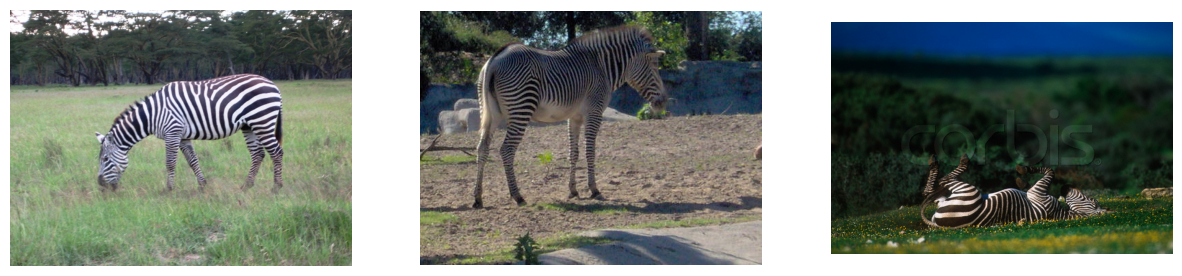

Images from dotted folder:


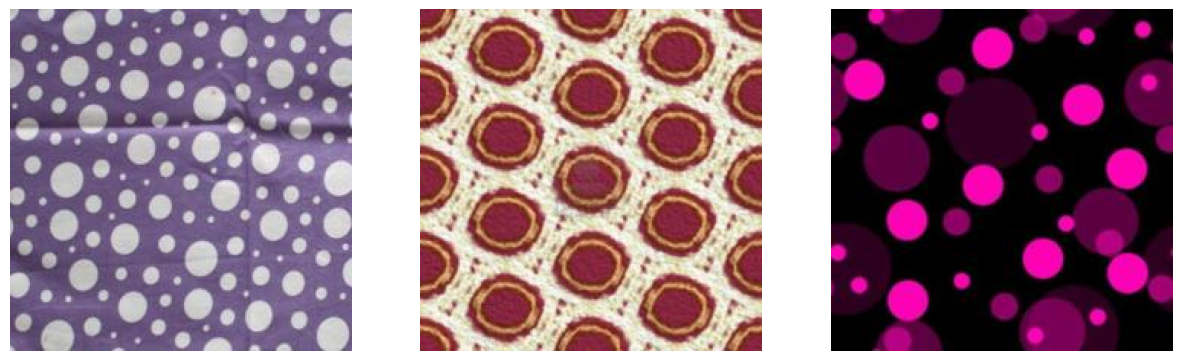

Images from striped folder:


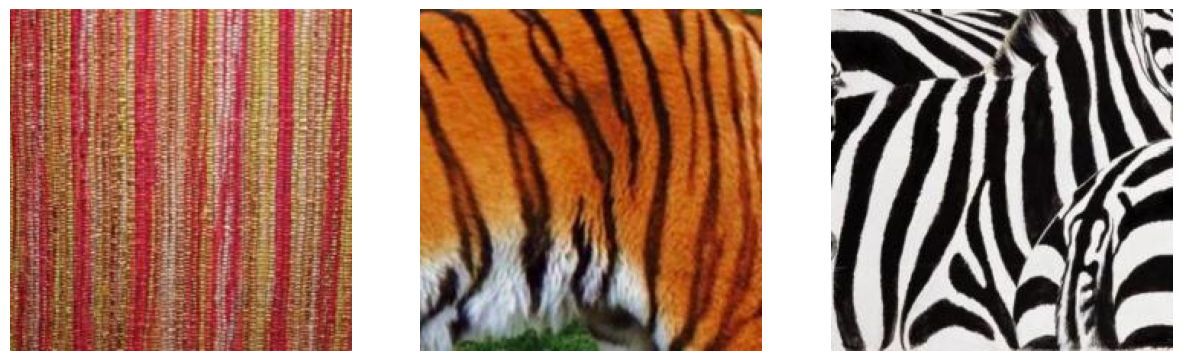

Images from zigzagged folder:


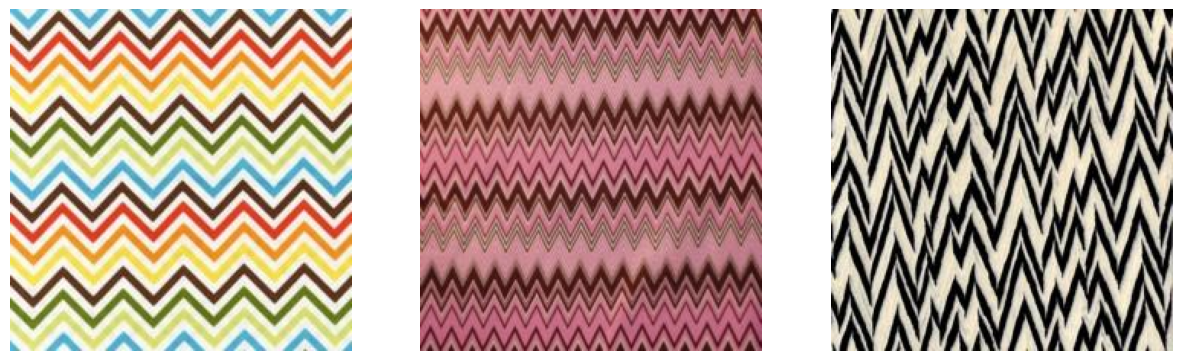

Images from random folder:


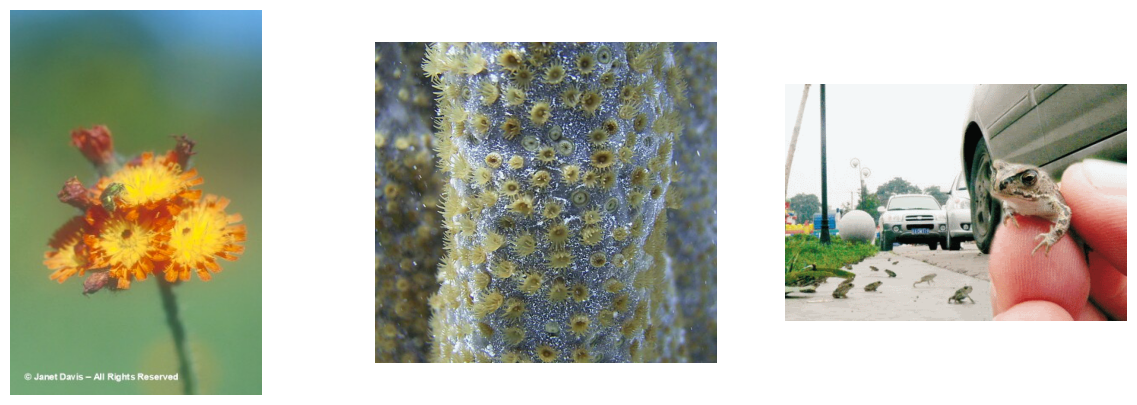

In [55]:
def display_random_images(directory, num_images):
    # Get list of files in the directory
    files = os.listdir(directory)

    # Filter out non-image files
    image_files = [f for f in files if f.endswith('.jpg')]

    # Check if there are enough image files
    if len(image_files) < num_images:
        print(f"Not enough images in {directory}.")
        return

    # Select random images
    random_images = random.sample(image_files, num_images)

    # Display selected images
    fig, axs = plt.subplots(1, num_images, figsize=(15, 5))
    for i, image_file in enumerate(random_images):
        image_path = os.path.join(directory, image_file)
        image = Image.open(image_path)
        axs[i].imshow(image)
        axs[i].axis('off')
    plt.show()

# Define source directory
source_dir = '/content/tcav/tcav/tcav_examples/image_models/imagenet/Minjie'
target = 'zebra'
concepts = ["dotted","striped","zigzagged"]
random_folder = 'random500_10'

# Display 3 images from the target folder in a row
print("Images from target folder:")
display_random_images(os.path.join(source_dir, target), 3)

# Display 3 images from each concept folder
for concept in concepts:
    print(f"Images from {concept} folder:")
    display_random_images(os.path.join(source_dir, concept), 3)

# Display 3 images from a random folder
print("Images from random folder:")
display_random_images(os.path.join(source_dir, random_folder), 3)


## Model Wrapper
See below for instructions on creating your own.

GRAPH_PATH is where the trained model is stored. LABEL_PATH is where the labels are stored

In [56]:
sess = utils.create_session() # a tensorflow session

GRAPH_PATH = "/content/tcav/tcav/inception5h/tensorflow_inception_graph.pb"
LABEL_PATH = "/content/tcav/tcav/inception5h/imagenet_comp_graph_label_strings.txt"

mymodel = model.GoogleNetWrapper_public(sess,GRAPH_PATH,LABEL_PATH)

ERROR:tensorflow:An interactive session is already active. This can cause out-of-memory errors or some other unexpected errors (due to the unpredictable timing of garbage collection) in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s). Please use `tf.Session()` if you intend to productionize.


## Return Avtivations

In [57]:
act_generator = act_gen.ImageActivationGenerator(mymodel, source_dir, activation_dir, max_examples=100)

## Run TCAV and show results

In [59]:
absl.logging.set_verbosity(0)
num_random_exp=10  # Recommend >10
mytcav = tcav.TCAV(sess,
                   target,
                   concepts,
                   bottlenecks,
                   act_generator,
                   alphas,
                   cav_dir=cav_dir,
                   num_random_exp=num_random_exp)#50)
print ('Started')
results = mytcav.run(run_parallel=False)
print ('Completed')

AttributeError: 'float' object has no attribute 'TCAV'

Class = zebra
  Concept = dotted
    Bottleneck = mixed4c. TCAV Score = 0.46 (+- 0.24), random was 0.49 (+- 0.25). p-val = 0.719 (not significant)
  Concept = striped
    Bottleneck = mixed4c. TCAV Score = 0.82 (+- 0.16), random was 0.49 (+- 0.25). p-val = 0.000 (significant)
  Concept = zigzagged
    Bottleneck = mixed4c. TCAV Score = 0.89 (+- 0.13), random was 0.49 (+- 0.25). p-val = 0.000 (significant)
{'mixed4c': {'bn_vals': [0.01, 0.825, 0.8875], 'bn_stds': [0, 0.16007810593582122, 0.13050383136138188], 'significant': [False, True, True]}}


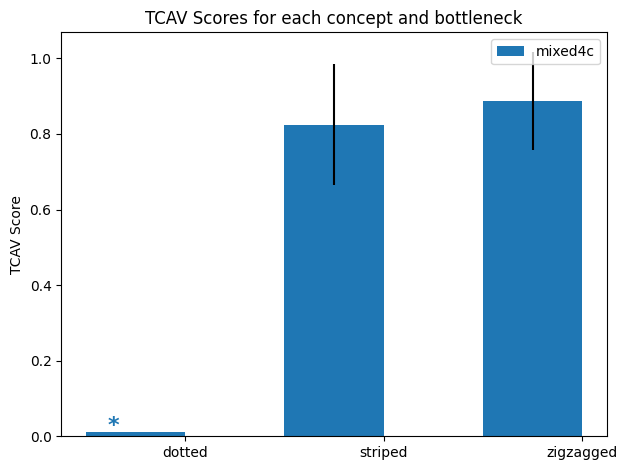

In [13]:
utils_plot.plot_results(results, num_random_exp=num_random_exp)


# Statistical Part

## Hypothesis:
H0: The GoogleNet model does not show a significant difference in its ability to learn the concept "zigzagged" compared to the concept "dotted" for the class ‘zebra’.



H1: The GoogleNet model shows a significant difference in its ability to learn the concept "zigzagged" compared to the concept "dotted" for the class ‘zebra’, specifically, it learns the concept "zigzagged" but not the concept "dotted".

In [50]:
import numpy as np
from scipy import stats

zigzagged_scores = [r['i_up'] for r in results if r['cav_concept'] == 'zigzagged']
dotted_scores = [r['i_up'] for r in results if r['cav_concept'] == 'dotted']


In [52]:
# 执行独立样本 t 检验
t_stat, p_value = stats.ttest_ind(zigzagged_scores, dotted_scores)

# 输出结果
print(f"T-statistic: {t_stat}, P-value: {p_value}")

# 根据 p 值判断是否拒绝原假设
if p_value < 0.05:
    print("两个概念的 TCAV 分数有显著差异。")
else:
    print("两个概念的 TCAV 分数没有显著差异。")

T-statistic: 4.704909160947312, P-value: 0.00017654142187945
两个概念的 TCAV 分数有显著差异。


0.1125